In [1]:
import sys
sys.path.append('..')
from MPRA_exp.utils import *
from MPRA_exp.metrics import *

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neural_network import MLPRegressor, MLPClassifier

In [2]:
main_df = pd.read_csv('data/Sei_Agarwal_features.csv')
main_df

,seq,chr,HepG2,K562,WTC11,HepG2_DNase_pred_logit,HepG2_H3K4me1_pred_logit,HepG2_H3K4me3_pred_logit,HepG2_H3K9me3_pred_logit,HepG2_H3K27me3_pred_logit,...,K562_H3K36me3_pred_logit,K562_CTCF_pred_logit,WTC11_DNase_pred_logit,WTC11_H3K4me1_pred_logit,WTC11_H3K4me3_pred_logit,WTC11_H3K9me3_pred_logit,WTC11_H3K27me3_pred_logit,WTC11_H3K27ac_pred_logit,WTC11_H3K36me3_pred_logit,WTC11_CTCF_pred_logit
0,GTAGGACCAGGCTCTGCCTCCTTCTCTCTCCCCCGACCCACCTGCC...,chr1,0.633,0.080,-0.387,-5.859295,-7.119490,-6.057355,-3.551522,-6.380669,...,-9.226210,-7.168854,-2.557880,-4.566425,-6.146413,-5.286354,-7.762058,-5.157560,-7.007315,NaN
1,TGTACTTGCCTTAGGAGGTCAAACACATTAGGTATACCAACATATC...,chr10,-1.157,-1.147,-1.507,-7.305344,-6.927581,-8.414853,-3.542766,-7.153573,...,-10.574494,-8.400257,-4.061095,-4.907909,-7.631953,-5.938999,-7.989648,-6.642758,-8.234763,NaN
2,TAGCTCAACACAAATCCATCACTGAAAGCAGTGCAACCAAGGCAGC...,chr10,-0.066,0.186,0.655,-0.782250,-6.342827,-6.081355,-4.035225,-7.667975,...,-7.529785,3.037210,2.743911,-6.389339,-6.379884,-6.150286,-7.534283,-6.674130,-7.502825,NaN
3,GACCCTAAATCAGTATGGGGAAAGGTCCCCACTGCAGCACTTTCTA...,chr10,0.846,1.212,-0.637,-4.273489,-6.010759,-6.726275,-4.673474,-8.190469,...,-10.120640,-7.559184,-1.334315,-4.937084,-6.713897,-6.826731,-7.590772,-4.083945,-8.286365,NaN
4,GTGATCTCAGCTTACTGCAACCTCTGCCTCCTGGGTTCAAGCAATT...,chr10,-0.784,-0.630,-0.612,-8.076906,-9.461184,-10.348317,-3.962570,-9.310516,...,-11.259768,-2.754237,-4.662179,-11.124068,-11.100749,-7.098486,-9.629781,-11.210427,-8.687329,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56970,CCAAGTCTGCCATCGTGTTCAGAAGGGCCAGAAATGCCAAGGACTC...,chrnan,-1.192,-1.080,-1.680,-8.466170,-8.186871,-8.400620,-3.860207,-6.952805,...,-11.044868,-9.203904,-5.971846,-9.095173,-9.085773,-6.396310,-8.253986,-8.845195,-8.223626,NaN
56971,CCAAGTCTGCCATCGTGTTCAGAAGGGCCAGAAATGCCAAGGACTC...,chrnan,-0.582,-1.094,-1.637,-6.227203,-6.022280,-7.381612,-3.749870,-7.992048,...,-10.345650,-9.076865,-5.591099,-8.998358,-9.882915,-6.664522,-8.420832,-8.861758,-8.470910,NaN
56972,CCAAGTCTGCCATCGTGTTCATGTTTGCTTTGAATGCCAAGGTGTT...,chrnan,-0.855,-0.554,-1.083,-0.061587,-3.795356,-5.825204,-5.810139,-8.793747,...,-9.901918,-7.850781,-3.858402,-7.112228,-8.424638,-8.954943,-6.221875,-8.489422,-8.402704,NaN
56973,CCAAGTCTGCCATCGTGTTCAGAAGGGCCAGAAATGCCAAGGACTC...,chrnan,-1.231,-0.927,-1.606,-8.206732,-7.431650,-9.003657,-3.964541,-7.953175,...,-11.222788,-9.579970,-6.391381,-9.245552,-10.055195,-6.624954,-8.851919,-8.959277,-8.838948,NaN


In [3]:
cell_types = ['HepG2', 'K562', 'WTC11']

main_df['diff_exp'] = (main_df[cell_types].max(axis=1) - main_df[cell_types].min(axis=1)) > 1
print(main_df['diff_exp'].sum())

20915


In [4]:
data_split_dict = {}
data_split_dict['total'] = np.ones(len(main_df), dtype=bool)
data_split_dict['chrom'] = main_df['chr'].isin([f'chr{i}' for i in range(1, 23)])
data_split_dict['train'] = main_df['chr'].isin([f'chr{i}' for i in range(3, 23)])
data_split_dict['valid'] = main_df['chr'].isin(['chr1'])
data_split_dict['test'] = main_df['chr'].isin(['chr2'])
data_split_dict['designed'] = main_df['chr'].isin(['chr0'])

exp_split_dict = {}
exp_split_dict['total'] = np.ones(len(main_df), dtype=bool)
exp_split_dict['const'] = ~main_df['diff_exp']
exp_split_dict['diff']  = main_df['diff_exp']

In [5]:
cell_types = ['HepG2', 'K562', 'WTC11']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
data_splits = ['chrom', 'designed']
exp_split = ['total', 'const', 'diff']

# for assay in assays:
#     for cell_type in cell_types:
#         for data_split in ['valid', 'test']:
#             for exp_split in exp_split_dict:
#                 condition = data_split_dict[data_split] & exp_split_dict[exp_split]
#                 x = main_df[condition][f'{cell_type}_{assay}_pred_logit']
#                 y = main_df[condition][cell_type]
#                 r = pearson(x, y)
#                 print(f'{cell_type} {assay} {data_split} {exp_split} pearson r = {r:.3f}')
#                 # r = spearman(x, y)
#                 # print(f'{cell_type} {assay} {data_split} total spearman r = {r:.3f}')
#     print()

for assay in assays:
    for cell_type in cell_types:
        for data_split in ['chrom']:
            for exp_split in ['total']:
                condition = data_split_dict[data_split] & exp_split_dict[exp_split]
                x = main_df[condition][f'{cell_type}_{assay}_pred_logit']
                y = main_df[condition][cell_type]
                r = pearson(x, y)
                print(f'{cell_type} {assay} {data_split} {exp_split} pearson r = {r:.3f}')
                # r = spearman(x, y)
                # print(f'{cell_type} {assay} {data_split} total spearman r = {r:.3f}')
    print()

# for assay in assays:
#     for cell_type in cell_types:
#         for data_split in data_splits:
#             for exp_split in ['total']:
#                 condition = data_split_dict[data_split] & exp_split_dict[exp_split]
#                 x = main_df[condition][f'{cell_type}_{assay}_pred_logit']
#                 y = main_df[condition][cell_type]
#                 r = pearson(x, y)
#                 print(f'{cell_type} {assay} {data_split} {exp_split} pearson r = {r:.3f}')
#                 # r = spearman(x, y)
#                 # print(f'{cell_type} {assay} {data_split} total spearman r = {r:.3f}')
#     print()

HepG2 DNase chrom total pearson r = 0.357
K562 DNase chrom total pearson r = 0.478
WTC11 DNase chrom total pearson r = 0.474

HepG2 H3K4me1 chrom total pearson r = 0.377
K562 H3K4me1 chrom total pearson r = 0.405
WTC11 H3K4me1 chrom total pearson r = 0.274

HepG2 H3K4me3 chrom total pearson r = 0.383
K562 H3K4me3 chrom total pearson r = 0.494
WTC11 H3K4me3 chrom total pearson r = 0.432

HepG2 H3K9me3 chrom total pearson r = -0.048
K562 H3K9me3 chrom total pearson r = 0.267
WTC11 H3K9me3 chrom total pearson r = 0.221

HepG2 H3K27me3 chrom total pearson r = 0.108
K562 H3K27me3 chrom total pearson r = 0.098
WTC11 H3K27me3 chrom total pearson r = 0.132

HepG2 H3K27ac chrom total pearson r = 0.396
K562 H3K27ac chrom total pearson r = 0.470
WTC11 H3K27ac chrom total pearson r = 0.287

HepG2 H3K36me3 chrom total pearson r = 0.252
K562 H3K36me3 chrom total pearson r = 0.350
WTC11 H3K36me3 chrom total pearson r = 0.345

HepG2 CTCF chrom total pearson r = -0.017
K562 CTCF chrom total pearson r =

/tmp/ipykernel_1812175/2301615523.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


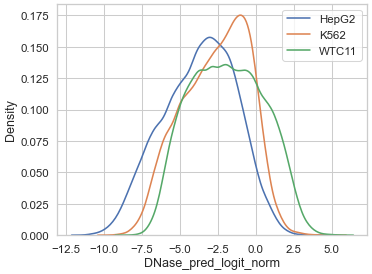

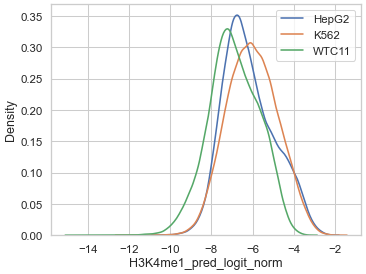

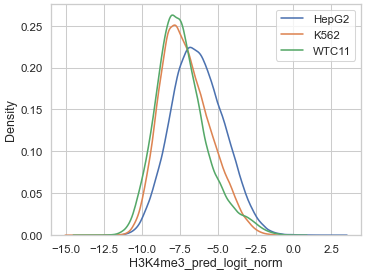

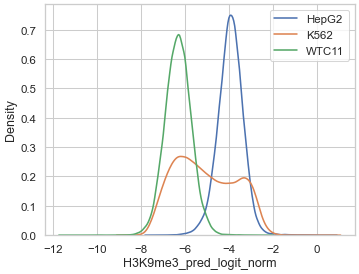

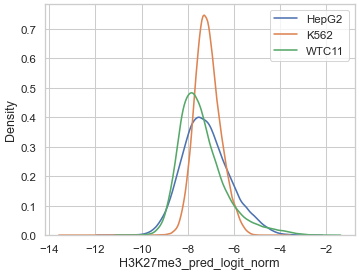

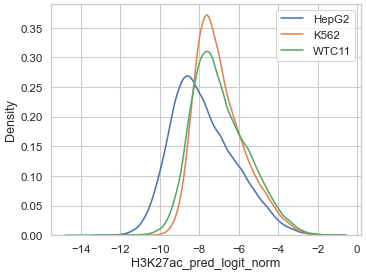

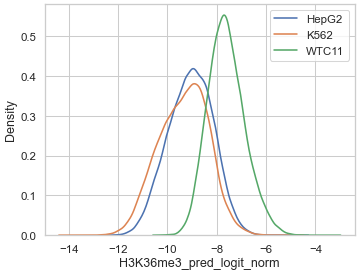

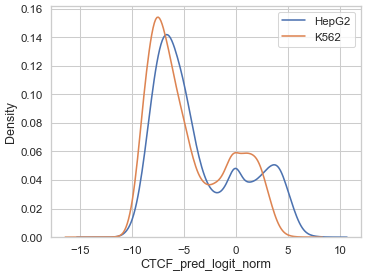

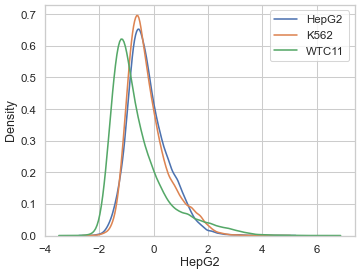

In [6]:
for assay in assays:
    plt.figure(figsize=(8, 6), dpi=50)
    for cell_type in cell_types:
        x = main_df[f'{cell_type}_{assay}_pred_logit']
        sns.kdeplot(x, label=cell_type)
        plt.xlabel(f'{assay}_pred_logit_norm')
        # sns.histplot(x, stat='density', bins=100, label=cell_type)
    plt.legend()


plt.figure(figsize=(8, 6), dpi=50)
for cell_type in cell_types:
        y = main_df[cell_type]
        sns.kdeplot(y, label=cell_type)
plt.legend()

In [7]:
# normalize to mean = 0
for assay in assays:
    for cell_type in cell_types:
        x = main_df[f'{cell_type}_{assay}_pred_logit']
        x_mean = np.mean(x)
        x_std = 1  # np.std(x)
        x = (x - x_mean) / x_std
        main_df[f'{cell_type}_{assay}_pred_logit_norm'] = x

# for cell_type in cell_types:
#     data_split = 'train'
#     selected_index = (main_df['chr'].isin(data_split_dict[data_split]))
#     y = main_df[selected_index][f'{cell_type}']
#     y_mean = 0
#     y_std = np.std(y)
#     main_df[f'{cell_type}_norm'] = (main_df[f'{cell_type}'] - y_mean) / y_std

/tmp/ipykernel_1812175/2488098897.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x, label=cell_type)


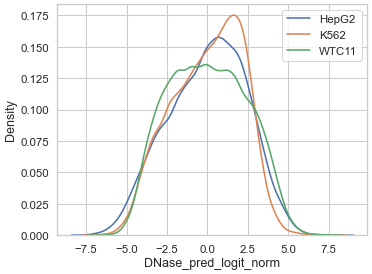

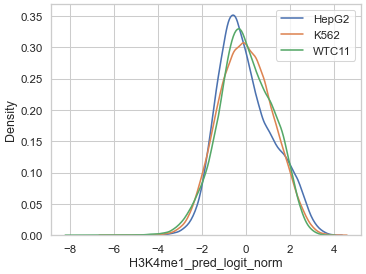

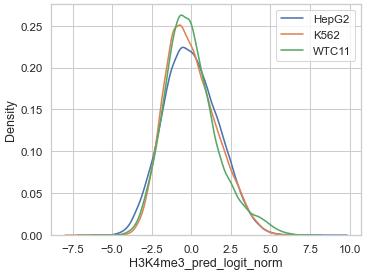

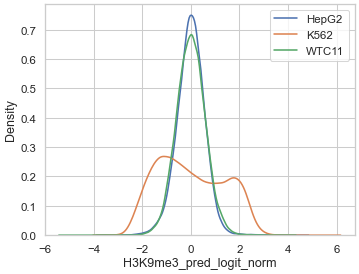

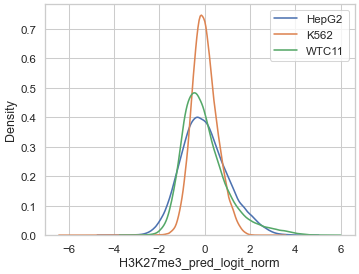

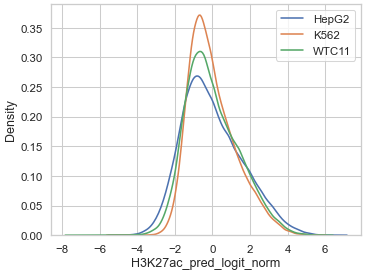

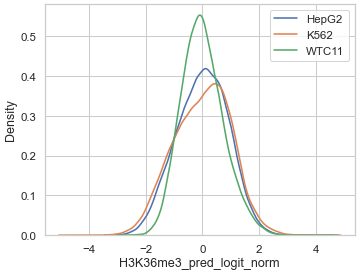

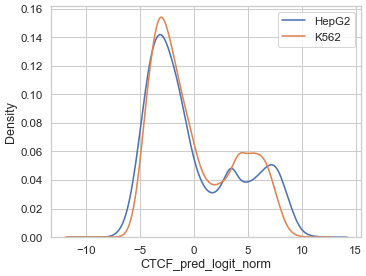

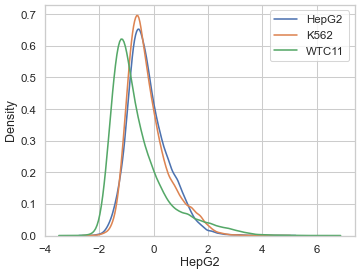

In [8]:
for assay in assays:
    plt.figure(figsize=(8, 6), dpi=50)
    for cell_type in cell_types:
        x = main_df[f'{cell_type}_{assay}_pred_logit_norm']
        sns.kdeplot(x, label=cell_type)
        plt.xlabel(f'{assay}_pred_logit_norm')
    plt.legend()


plt.figure(figsize=(8, 6), dpi=50)
for cell_type in cell_types:
        y = main_df[cell_type]
        sns.kdeplot(y, label=cell_type)
plt.legend()

In [11]:
# cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
cell_types = ['HepG2', 'K562', 'WTC11']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
data_splits = ['total', 'train', 'valid', 'test']


for assay in assays:

    r_matrix = np.zeros((len(cell_types), len(data_splits)))
    r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)

    for cell_type in cell_types:
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            df = main_df[condition]
            x = df[f'{cell_type}_{assay}_pred_logit_norm']
            y = df[f'{cell_type}']
            r = pearson(x, y)
            r_matrix[data_split][cell_type] = r
    print(assay)
    print(r_matrix)
    print()

DNase
          total     train     valid      test
HepG2  0.367538  0.350888  0.385807  0.375143
K562   0.482711  0.476592  0.474929  0.494027
WTC11  0.477240  0.468212  0.485297  0.514823

H3K4me1
          total     train     valid      test
HepG2  0.386047  0.372185  0.406981  0.393371
K562   0.404375  0.401538  0.417361  0.422497
WTC11  0.276276  0.267939  0.295194  0.301542

H3K4me3
          total     train     valid      test
HepG2  0.387008  0.381152  0.399815  0.376184
K562   0.496062  0.494004  0.486234  0.504146
WTC11  0.430981  0.427122  0.438599  0.463446

H3K9me3
          total     train     valid      test
HepG2 -0.049534 -0.045428 -0.065175 -0.048080
K562   0.267568  0.266321  0.258612  0.269605
WTC11  0.222823  0.221324  0.224013  0.208277

H3K27me3
          total     train     valid      test
HepG2  0.113453  0.107072  0.124981  0.093761
K562   0.100766  0.095269  0.101826  0.112477
WTC11  0.128315  0.126400  0.152170  0.158690

H3K27ac
          total     train   

In [12]:
# # normalize input
# cell_types = ['HepG2', 'K562', 'A549', 'HCT116']
cell_types = ['HepG2', 'K562', 'WTC11']
# assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3', 'CTCF']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']
data_splits = ['total', 'train', 'valid', 'test']


r_matrix = np.zeros((len(cell_types), len(data_splits)))
r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)

for cell_type in cell_types:
    # train
    data_split = 'train'
    print(f'train model by {cell_type} {data_split} data')
    condition = data_split_dict[data_split]
    df = main_df[condition]
    selected_columns = [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
    X_train = np.array(df[selected_columns])
    y_train = np.array(df[f'{cell_type}'])

    X_train, y_train = remove_nan(X_train, y_train)
    if len(X_train) == 0:
        continue
    
    model = LinearRegression()
    # model = Lasso(alpha=1e-3)
    # model = MLPRegressor(hidden_layer_sizes=10, alpha=1e-3)
    model.fit(X_train, y_train)

    # valid
    for cell_type in cell_types:
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            df = main_df[condition]
            selected_columns = [f'{cell_type}_{assay}_pred_logit_norm' for assay in assays]
            X_valid = np.array(df[selected_columns])
            y_valid = np.array(df[f'{cell_type}'])

            X_valid, y_valid = remove_nan(X_valid, y_valid)
            if len(X_valid) == 0:
                continue
            y_pred = model.predict(X_valid)
            r = pearson(y_valid, y_pred)
            r_matrix[data_split][cell_type] = r

            # print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")
    print(r_matrix)
    print()

train model by HepG2 train data
          total     train     valid      test
HepG2  0.484266  0.476544  0.508754  0.476618
K562   0.530068  0.528858  0.530282  0.534783
WTC11  0.529279  0.525232  0.537068  0.530291

train model by K562 train data
          total     train     valid      test
HepG2  0.403812  0.397424  0.421459  0.409286
K562   0.598848  0.596684  0.593620  0.590625
WTC11  0.579791  0.573113  0.590428  0.594798

train model by WTC11 train data
          total     train     valid      test
HepG2  0.441325  0.433535  0.467386  0.433064
K562   0.558084  0.555168  0.557968  0.557542
WTC11  0.649891  0.645407  0.653314  0.658850



In [15]:
# leave-one-out cross-validation
# input norm

cell_types = ['HepG2', 'K562', 'WTC11']
assays = ['DNase', 'H3K4me1', 'H3K4me3', 'H3K9me3', 'H3K27me3', 'H3K27ac', 'H3K36me3']
data_splits = ['train', 'valid', 'test', 'designed']


valid_r_matrix = np.zeros((len(cell_types), len(data_splits)))
valid_r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)


for cell_type in cell_types:
    r_matrix = np.zeros((len(cell_types), len(data_splits)))
    r_matrix = pd.DataFrame(r_matrix, index=cell_types, columns=data_splits)

    # train
    data_split = 'train'
    print(f'train model by not {cell_type} data')

    X_train = []
    y_train = []
    for train_cell_type in cell_types:
        if train_cell_type == cell_type:
            continue
        condition = data_split_dict[data_split]
        df = main_df[condition]

        X_columns = [f'{train_cell_type}_{assay}_pred_logit_norm' for assay in assays]
        y_column = train_cell_type
        X_train.append(df[X_columns])
        y_train.append(df[y_column])

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_train, y_train = remove_nan(X_train, y_train)
    if len(X_train) == 0:
        continue

    model = LinearRegression()
    # model = Lasso(alpha=1e-3)
    # model = MLPRegressor(hidden_layer_sizes=10, alpha=1e-3)
    model.fit(X_train, y_train)

    # valid
    for valid_cell_type in cell_types:
        for data_split in data_splits:
            condition = data_split_dict[data_split]
            df = main_df[condition]

            X_columns = [f'{valid_cell_type}_{assay}_pred_logit_norm' for assay in assays]
            y_column = valid_cell_type
            X_valid = np.array(df[X_columns])
            y_valid = np.array(df[y_column])

            X_valid, y_valid = remove_nan(X_valid, y_valid)
            if len(X_valid) == 0:
                continue
            y_pred = model.predict(X_valid)
            r = pearson(y_valid, y_pred)
            
            r_matrix[data_split][valid_cell_type] = r
            # print(f"{valid_cell_type} {data_split} Pearson's r: {r:.3f}")
            if valid_cell_type == cell_type:
                valid_r_matrix[data_split][cell_type] = r
    print(r_matrix)
    print()

print('\n\ntotal leave one out validation')
print(valid_r_matrix)

train model by not HepG2 data
len(x) = 0
len(x) = 0
len(x) = 0
          train     valid      test  designed
HepG2  0.416548  0.443811  0.417575       0.0
K562   0.587635  0.583562  0.586540       0.0
WTC11  0.626899  0.639517  0.647955       0.0

train model by not K562 data
len(x) = 0
len(x) = 0
len(x) = 0
          train     valid      test  designed
HepG2  0.450606  0.477688  0.450045       0.0
K562   0.548556  0.543294  0.553863       0.0
WTC11  0.621263  0.631486  0.636255       0.0

train model by not WTC11 data
len(x) = 0
len(x) = 0
len(x) = 0
          train     valid      test  designed
HepG2  0.458478  0.487368  0.462639       0.0
K562   0.572626  0.572931  0.573111       0.0
WTC11  0.597491  0.611582  0.608446       0.0



total leave one out validation
          train     valid      test  designed
HepG2  0.416548  0.443811  0.417575       0.0
K562   0.548556  0.543294  0.553863       0.0
WTC11  0.597491  0.611582  0.608446       0.0
